In [ ]:
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
sns.set_theme()
import seaborn.objects as so
import matplotlib.pyplot as plt

In [ ]:
# from scipy.special import loggamma, gammaln, xlogy
# import numpy as np

# def sequential_p_value(counts, assignment_probabilities, dirichlet_alpha=None):
#     """
#     Compute the sequential p-value for given counts and assignment probabilities.
#     Lindon, Michael, and Alan Malek.
#     "Anytime-Valid Inference For Multinomial Count Data."
#     In Advances in Neural Information Processing Systems, 2022
#     https://openreview.net/pdf?id=a4zg0jiuVi
#     Parameters
#     ----------
#     counts : array like
#         The observed counts in each treatment group.
#     assignment_probabilities : array like
#         The assignment probabilities to each treatment group.
#     dirichlet_alpha : array like, optional
#         The Dirichlet mixture parameter.
#     Returns
#     -------
#     float
#         The sequential p-value.
#     """
#     counts = np.array(counts)
#     assignment_probabilities = np.array(assignment_probabilities)
#     if dirichlet_alpha is None:
#         dirichlet_alpha = 100 * assignment_probabilities
#     else:
#         dirichlet_alpha = np.array(dirichlet_alpha)
#     lm1 = (
#         loggamma(counts.sum() + 1)
#         - loggamma(counts + 1).sum()
#         + loggamma(dirichlet_alpha.sum())
#         - loggamma(dirichlet_alpha).sum()
#         + loggamma(dirichlet_alpha + counts).sum()
#         - loggamma((dirichlet_alpha + counts).sum())
#     )
#     lm0 = gammaln(counts.sum() + 1) + np.sum(
#         xlogy(counts, assignment_probabilities) - gammaln(counts + 1), axis=-1
#     )
#     return min(1, np.exp(lm0 - lm1))

In [ ]:
from scipy.special import loggamma, gammaln, xlogy
import numpy as np

def sequential_p_value(counts, assignment_probabilities, dirichlet_alpha=None):
    counts = np.array(counts)
    assignment_probabilities = np.array(assignment_probabilities)
    if dirichlet_alpha is None:
        dirichlet_alpha = 100 * assignment_probabilities
    else:
        dirichlet_alpha = np.array(dirichlet_alpha)

    log_bf = (
        loggamma(dirichlet_alpha + counts).sum() - loggamma((dirichlet_alpha + counts).sum())
        - loggamma(dirichlet_alpha).sum() + loggamma(dirichlet_alpha.sum())
        - np.sum(xlogy(counts, assignment_probabilities))
    )

    return min(1, np.exp(-log_bf))

In [ ]:
def simulate_once(n_seq, prob_assignment, prob_conversion, rng):
    n_groups = prob_assignment.shape[0]
    counts = np.zeros((n_groups, n_seq + 1))
    assignments = np.zeros((n_groups, n_seq + 1))
    for i in range(n_seq):
        group = rng.choice(n_groups, p = prob_assignment)
        assignments[:, i + 1] = assignments[:, i]
        assignments[group, i + 1] += 1

        success = rng.binomial(1, prob_conversion[group])
        counts[:, i + 1] = counts[:, i]
        counts[group, i + 1] += int(success)

    return assignments, counts

In [ ]:
def simulate_multi(n_exp, n_seq, prob_assignment, prob_conversion, rng):
    n_groups = prob_assignment.shape[0]
    counts = np.zeros((n_exp, n_groups, n_seq + 1))
    assignments = np.zeros((n_exp, n_groups, n_seq + 1))
    for i in range(n_exp):
        assign, cnt = simulate_once(n_seq, prob_assignment, prob_conversion, rng)
        counts[i] = cnt
        assignments[i] = assign
    return counts, assignments

In [ ]:
prob_assignment = np.array([0.5, 0.5])
prob_conversion = np.array([0.5, 0.5])

n_exp = 1000
n_seq = 4000

rng = np.random.default_rng(0)

counts, assignments = simulate_multi(n_exp, n_seq, prob_assignment, prob_conversion, rng)

In [ ]:
estimated_prob = counts[:, :, 10:] / assignments[:, :, 10:]

<ipython-input-7-3dcd56ae5909>:1: RuntimeWarning: invalid value encountered in divide
  estimated_prob = counts[:, :, 10:] / assignments[:, :, 10:]


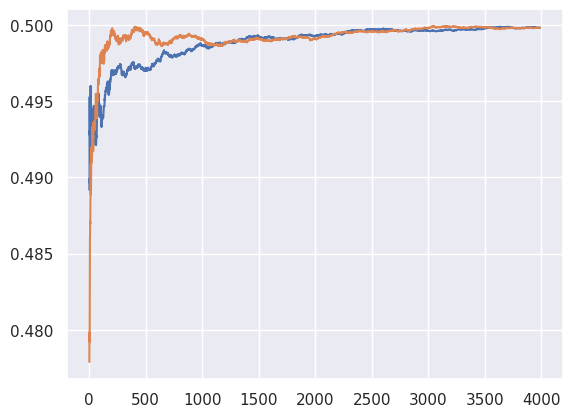

In [ ]:
plt.plot(estimated_prob[:, 0, :].mean(axis=0))
plt.plot(estimated_prob[:, 1, :].mean(axis=0))

In [ ]:
def calc_sequential_pvalues(counts, prob_assignment):
    ps = [1]
    for i in range(counts.shape[1]):
        p = sequential_p_value(counts[:, i], prob_assignment)
        ps.append(min(ps[-1], p))
    return ps

In [ ]:
def chi2_pvalue(counts, assignments):
    conversion = counts
    non_conversion = assignments - conversion
    table = np.vstack((conversion, non_conversion))
    if (table.sum(axis=0)==0).any() or (table.sum(axis=1)==0).any():
        return 1
    _, p, _, _ = chi2_contingency(table)
    return p

def calc_chi2_pvalues(counts, assignments):
    ps = [1]
    for i in range(counts.shape[1]):
        p = chi2_pvalue(counts[:, i], assignments[:, i])
        ps.append(min(ps[-1], p))
    return ps

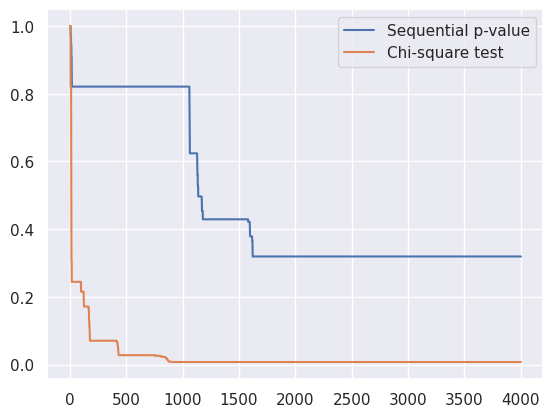

In [ ]:
ps_exp0 = calc_sequential_pvalues(counts[0], prob_assignment)
ps_chi2_exp0 = calc_chi2_pvalues(counts[0], assignments[0])
plt.plot(ps_exp0, label="Sequential p-value")
plt.plot(ps_chi2_exp0, label="Chi-square test")
plt.legend()

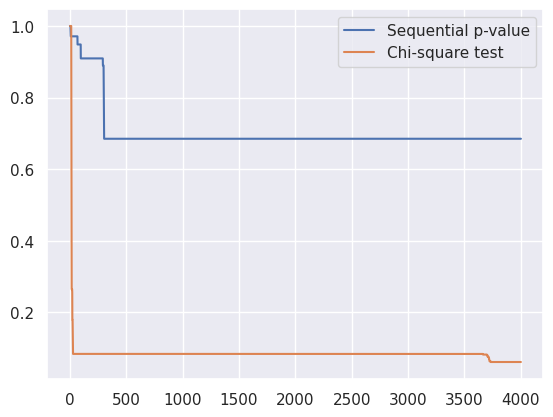

In [ ]:
ps_exp0 = calc_sequential_pvalues(counts[1], prob_assignment)
ps_chi2_exp0 = calc_chi2_pvalues(counts[1], assignments[1])
plt.plot(ps_exp0, label="Sequential p-value")
plt.plot(ps_chi2_exp0, label="Chi-square test")
plt.legend()

In [ ]:
ps = [calc_sequential_pvalues(counts[i], prob_assignment)[-1] for i in range(counts.shape[0])]
ps_chi2 = [calc_chi2_pvalues(counts[i], assignments[i])[-1] for i in range(counts.shape[0])]

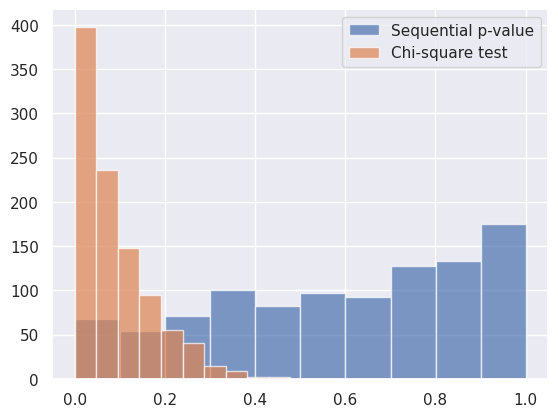

In [ ]:
plt.hist(ps, alpha=0.7, label="Sequential p-value")
plt.hist(ps_chi2, alpha=0.7, label="Chi-square test")
plt.legend()

In [ ]:
(np.array(ps) < 0.05).mean(), (np.array(ps_chi2) < 0.05).mean()

(0.032, 0.41)

In [ ]:
prob_conversion = np.array([0.54, 0.5])
rng = np.random.default_rng(0)

counts, assignments = simulate_multi(n_exp, n_seq, prob_assignment, prob_conversion, rng)

In [ ]:
estimated_prob = counts[:, :, 10:] / assignments[:, :, 10:]

<ipython-input-17-3dcd56ae5909>:1: RuntimeWarning: invalid value encountered in divide
  estimated_prob = counts[:, :, 10:] / assignments[:, :, 10:]


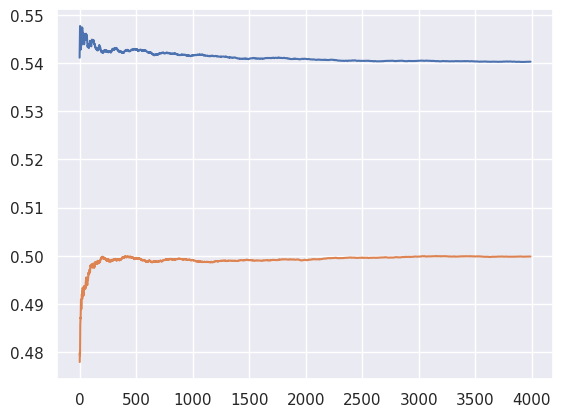

In [ ]:
plt.plot(estimated_prob[:, 0, :].mean(axis=0))
plt.plot(estimated_prob[:, 1, :].mean(axis=0))

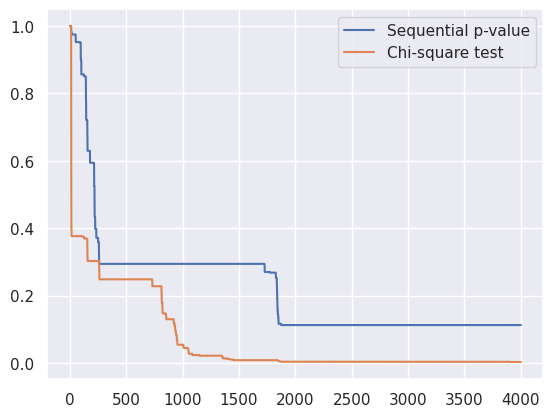

In [ ]:
ps_exp0 = calc_sequential_pvalues(counts[0], prob_assignment)
ps_chi2_exp0 = calc_chi2_pvalues(counts[0], assignments[0])
plt.plot(ps_exp0, label="Sequential p-value")
plt.plot(ps_chi2_exp0, label="Chi-square test")
plt.legend()

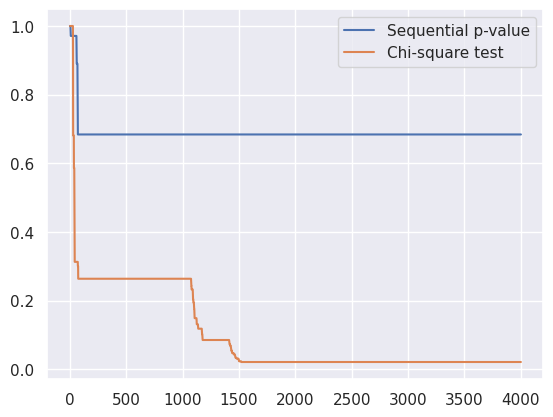

In [ ]:
ps_exp0 = calc_sequential_pvalues(counts[1], prob_assignment)
ps_chi2_exp0 = calc_chi2_pvalues(counts[1], assignments[1])
plt.plot(ps_exp0, label="Sequential p-value")
plt.plot(ps_chi2_exp0, label="Chi-square test")
plt.legend()

In [ ]:
ps = [calc_sequential_pvalues(counts[i], prob_assignment)[-1] for i in range(counts.shape[0])]
ps_chi2 = [chi2_pvalue(counts[i, :, -1], assignments[i, :, -1]) for i in range(counts.shape[0])]

(array([812.,  80.,  41.,  28.,   6.,  11.,   3.,   6.,   5.,   8.]),
 array([2.42105187e-09, 1.00000002e-01, 2.00000002e-01, 3.00000002e-01,
        4.00000001e-01, 5.00000001e-01, 6.00000001e-01, 7.00000001e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

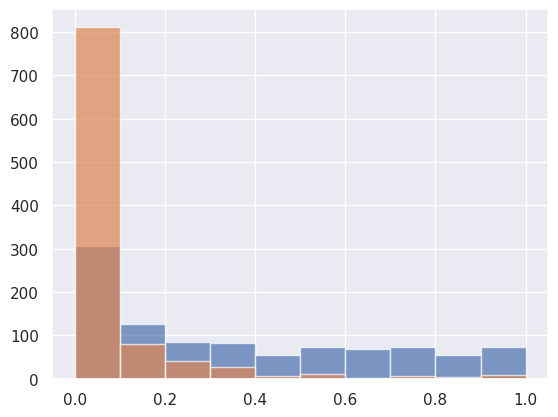

In [ ]:
plt.hist(ps, alpha=0.7)
plt.hist(ps_chi2, alpha=0.7)

In [ ]:
(np.array(ps) < 0.05).mean(), (np.array(ps_chi2) < 0.05).mean()

(0.202, 0.715)